# Beta Neutral Portfolio

Diego Alvarez <br> diego.alvarez@colorado.edu

# Background

In this case we are going to build some example beta neutral portfolios. Both will use the OLS methodology for finding beta and alpha, although one will use the Gerber calculation and the other will use the standard covariance calculation. 

# Packages

In [1]:
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

Acesss Gerber Object

In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))
from Gerber import Gerber

# Beta Neutral Sector Excess Return

## Collect Data

In [3]:
from GetETFData import *
df_raw = GetETF().collect()

## Prep Data

In [4]:
df_adj_close = (df_raw.query(
    "variable_0 == 'Adj Close'").
    drop(columns = ["variable_0"]).
    rename(columns = {"variable_1": "ticker"}))

In [5]:
df_fund_info = (pd.read_csv(
    filepath_or_buffer = "tickers.csv",
    index_col = 0).
    rename(columns = {"Symbol": "ticker"}))

In [6]:
df_stats = (df_adj_close.dropna()[
    ["ticker", "Date"]].
    groupby("ticker").
    agg(["min", "max", "count"])
    ["Date"].
    sort_values("count").
    reset_index().
    merge(right = df_fund_info, how = "inner", on = "ticker").
    assign(
        fund_name = lambda x: x["Fund Name"].str.replace("ETF","").str.replace("Fund", "").str.replace("SPDR", "").str.replace("Sector", ""),
        name = lambda x: x.fund_name + "\n" + x["min"].dt.year.astype(str) + "-" + x["max"].dt.year.astype(str)).
    set_index("name")
    [["count", "ticker"]].
    sort_values("count", ascending = False))

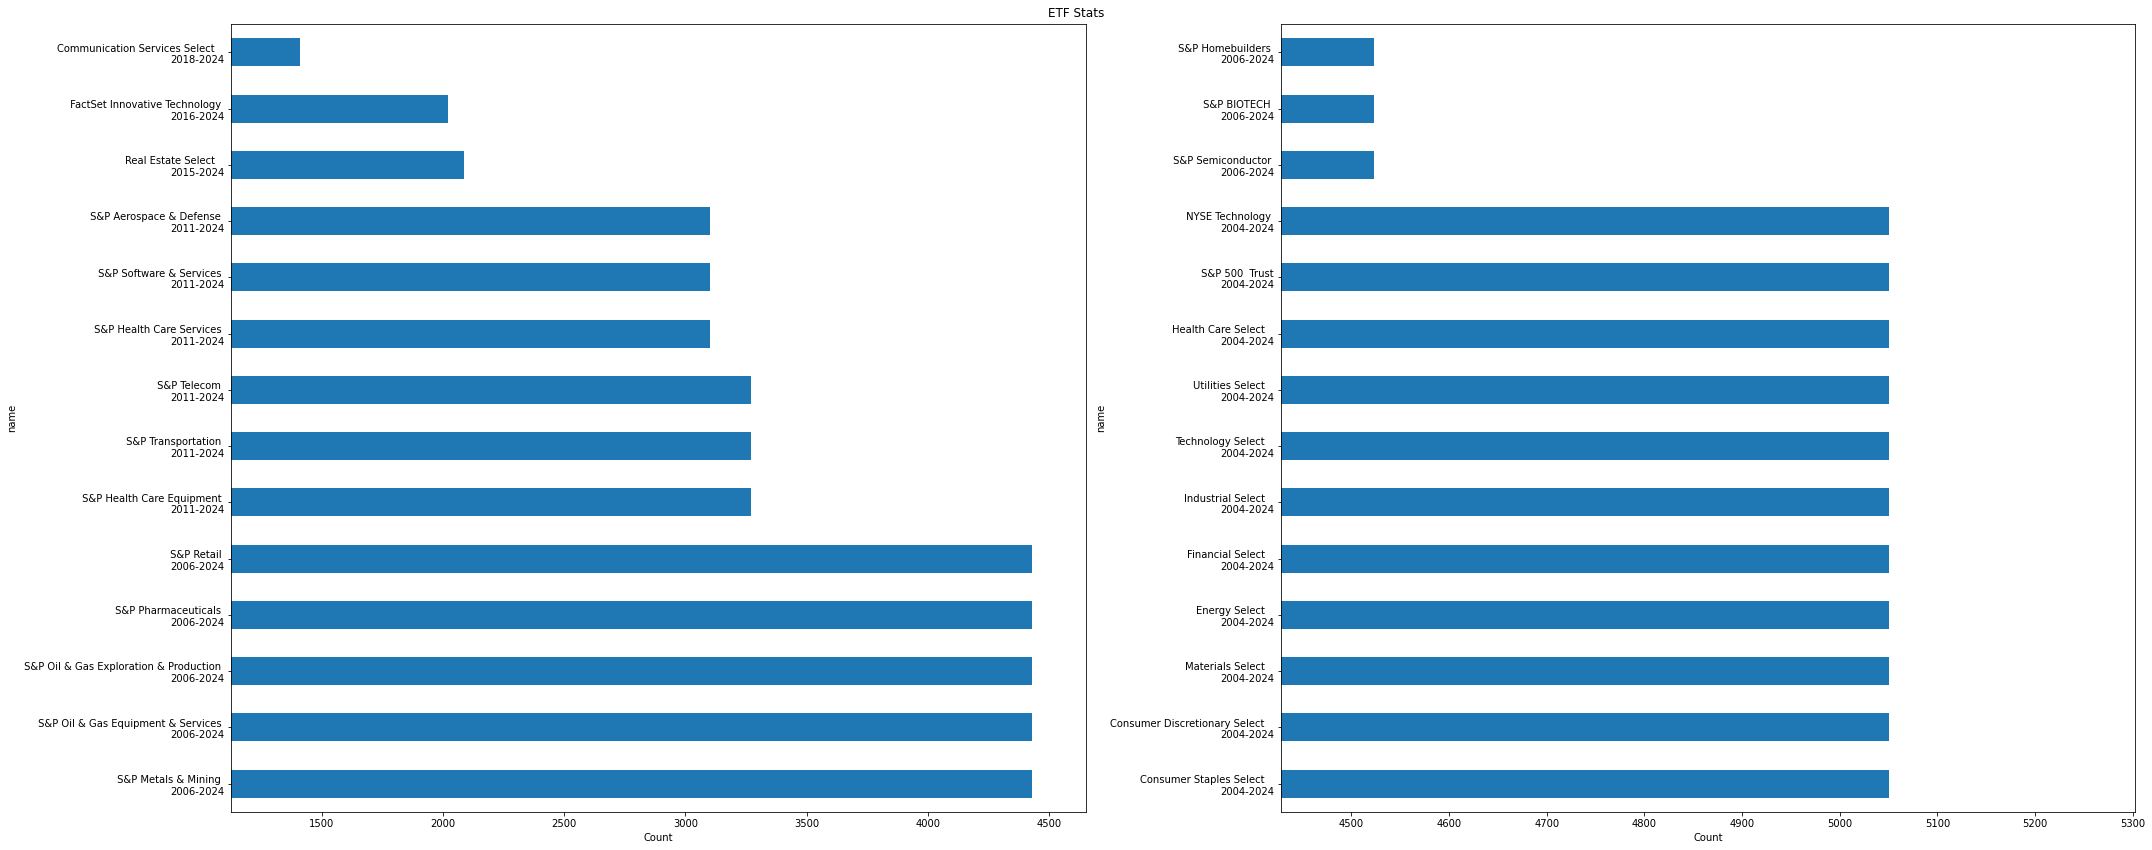

In [7]:
first_half, second_half = df_stats[0:int(len(df_stats)/2)], df_stats[int(len(df_stats)/2):-1]
fig, axes = plt.subplots(ncols = 2, figsize = (30,12))


(second_half.plot(
    kind = "barh",
    ax = axes[0],
    xlim = (second_half["count"].min() * 0.8)))

(first_half.plot(
    kind = "barh",
    ax = axes[1],
    xlim = (second_half["count"].max())))

for ax in axes: ax.set_xlabel("Count"); ax.legend().remove()

fig.suptitle("ETF Stats")
plt.tight_layout()

Going to use a quantile cut for data size

In [8]:
good_tickers = df_stats.query("count > 3_000").ticker.drop_duplicates().to_list()

In [9]:
df_prep = (df_adj_close.query(
    "ticker == @good_tickers").
    pivot(index = "Date", columns = "ticker", values = "value").
    pct_change().
    dropna().
    reset_index().
    melt(id_vars = ["Date", "SPY"], value_name = "sector_rtn").
    set_index("Date"))

## Data Stats

In [10]:
def _rollingOLS(
    df: pd.DataFrame,
    window: float = 60):
    
    etf = df.ticker.iloc[0]
    print("Working on", etf)
    
    df_tmp = df.sort_index()
    endog, exog = df_tmp.sector_rtn, df_tmp.SPY
    
    df_ols = (RollingOLS(
        endog = endog, exog = sm.add_constant(exog), window = window).
        fit())
    
    df_ols_params = (df_ols.params.rename(
        columns = {
            "const": "alpha",
            "SPY": "beta"}).
        assign(
            date = lambda x: df_tmp.index,
            regression = "OLS").
        dropna().
        reset_index(drop = True))
    
    df_gerber_params = (Gerber().RollingGerberOLS(
        endog = endog, exog = exog, window = window).
        assign(
            regression = "Gerber").
        dropna())
    
    df_out = pd.concat([df_ols_params, df_gerber_params])
    
    return df_out

In [13]:
try: 
    df_ols = pd.read_parquet(path = "regressions.parquet", engine = "pyarrow")
    
except: 
    
    df_ols = (df_prep.groupby(
        "ticker").
        apply(_rollingOLS).
        reset_index().
        drop(columns = ["level_1"]))
    
    df_ols.to_parquet(path = "regressions.parquet", engine = "pyarrow")

In [80]:
df_fund_name = (df_stats.reset_index().assign(
    fund_name = lambda x: x.name.str.split("\n").str[0])
    [["fund_name", "ticker"]])

df_regression = (df_ols.merge(
    right = df_fund_name, how = "inner", on = ["ticker"]).
    assign(name = lambda x: (x.ticker + ":" + x.fund_name).str.strip()))

In [96]:
def make_line_chart(
    df: pd.DataFrame,
    col: str,
    figsize: tuple = (30,15)):

    names = df.name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = 4, nrows = 6, figsize = figsize)

    if len(axes.reshape(-1)) == len(names): 
        for i, ax in enumerate(axes.reshape(-1)):

            name = names[i]
            df_tmp = (df.query(
                "name == @name")
                [["regression", col, "date"]].
                pivot(index = "date", columns = "regression", values = col))

            (df_tmp.dropna().plot(
                ax = ax,
                title = ticker,
                legend = False,
                ylabel = col))

    fig.suptitle("Sector ETF {} From Regression against SPY\nBlue: Gerber, Orange: OLS from {} to {}".format(
        col,
        df_ols.date.min().date(),
        df_ols.date.max().date()))

    plt.tight_layout()

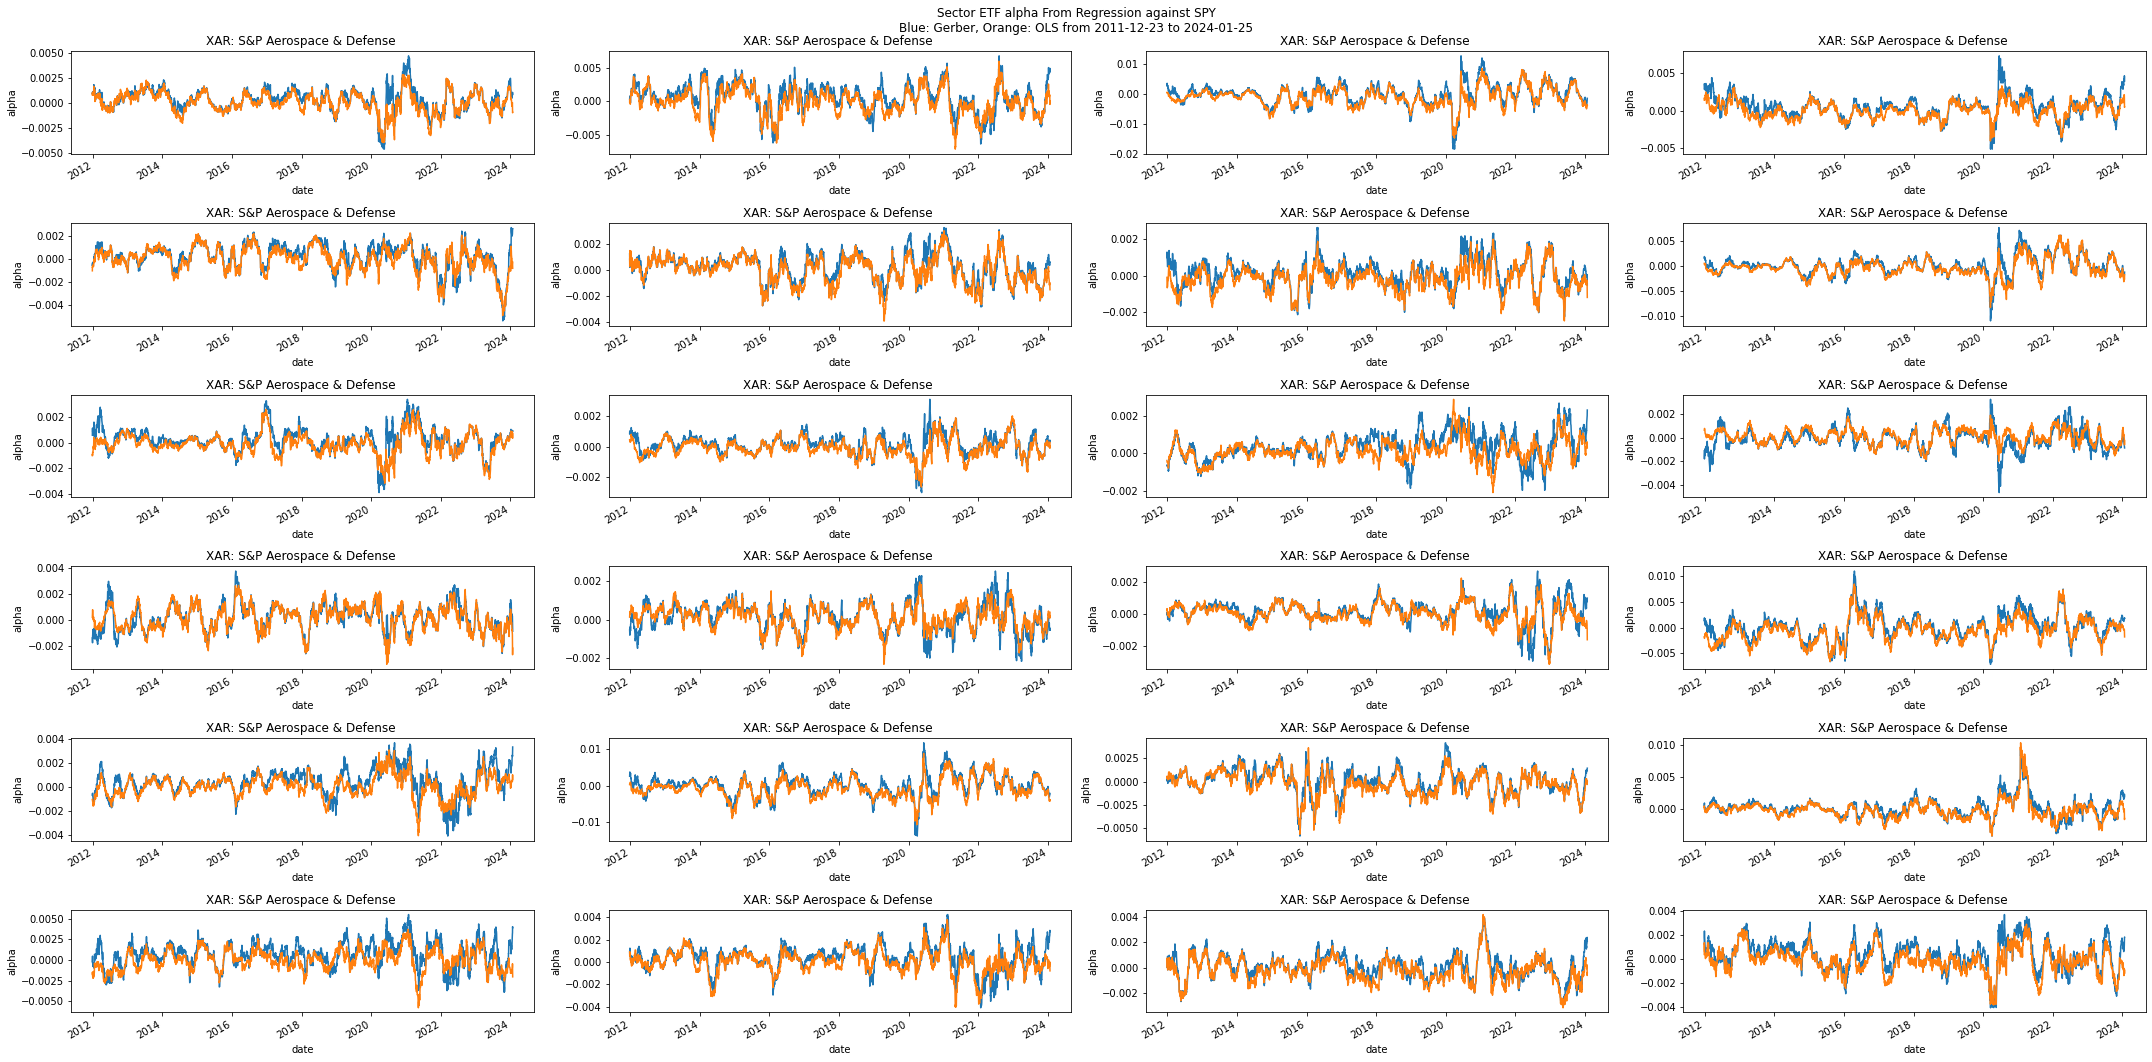

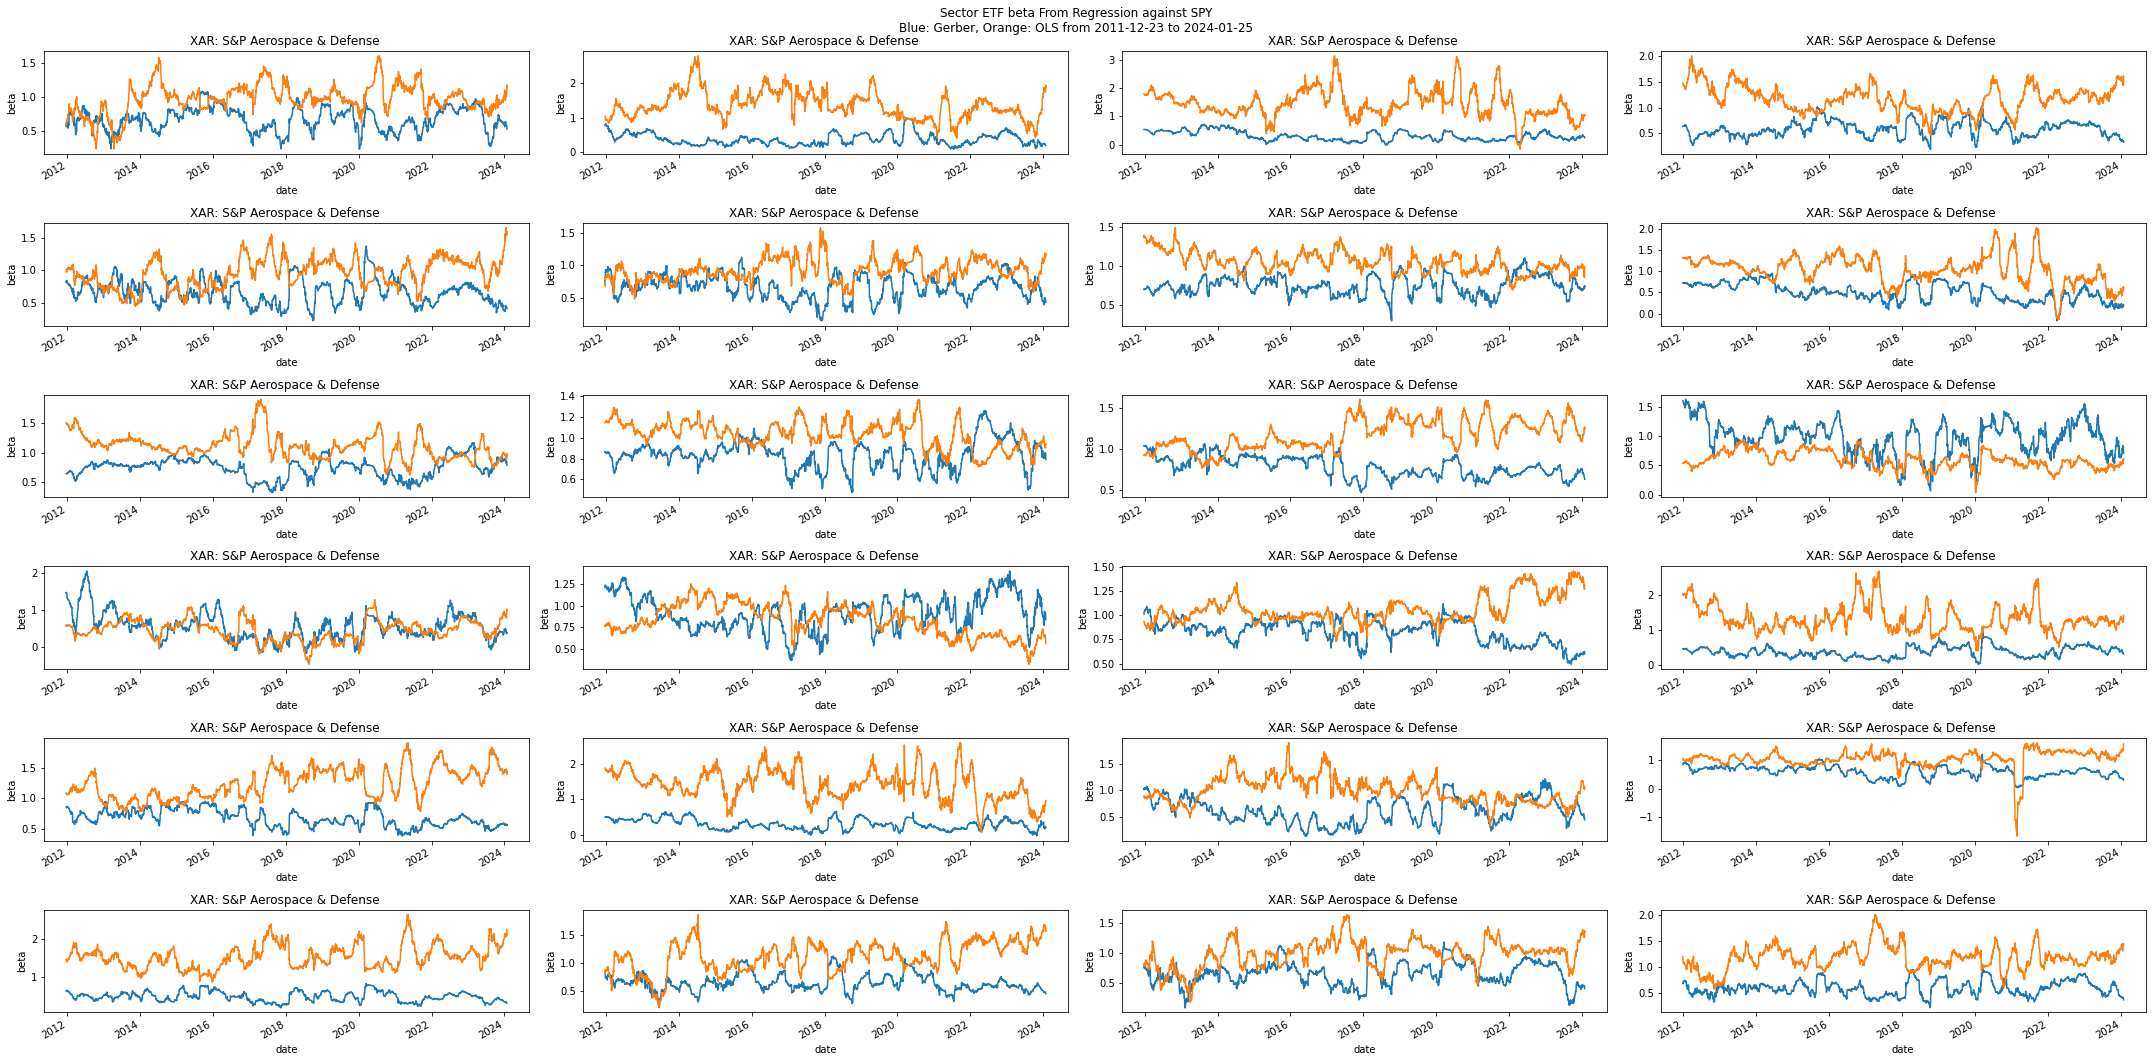

In [97]:
make_line_chart(df_regression, "alpha")
make_line_chart(df_regression, "beta")

In [102]:
def make_hist_chart(
    df: pd.DataFrame,
    col: str,
    figsize: tuple = (30,15)):

    names = df.name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = 4, nrows = 6, figsize = figsize)

    if len(axes.reshape(-1)) == len(names): 
        for i, ax in enumerate(axes.reshape(-1)):

            name = names[i]
            df_tmp = (df.query(
                "name == @name")
                [["regression", col, "date"]].
                pivot(index = "date", columns = "regression", values = col))

            (df_tmp.dropna().plot(
                kind = "hist",
                ax = ax,
                bins = 30,
                alpha = 0.5,
                title = ticker,
                legend = False,
                ylabel = col))

    fig.suptitle("Sector ETF {} From Regression against SPY\nBlue: Gerber, Orange: OLS from {} to {}".format(
        col,
        df_ols.date.min().date(),
        df_ols.date.max().date()))

    plt.tight_layout()

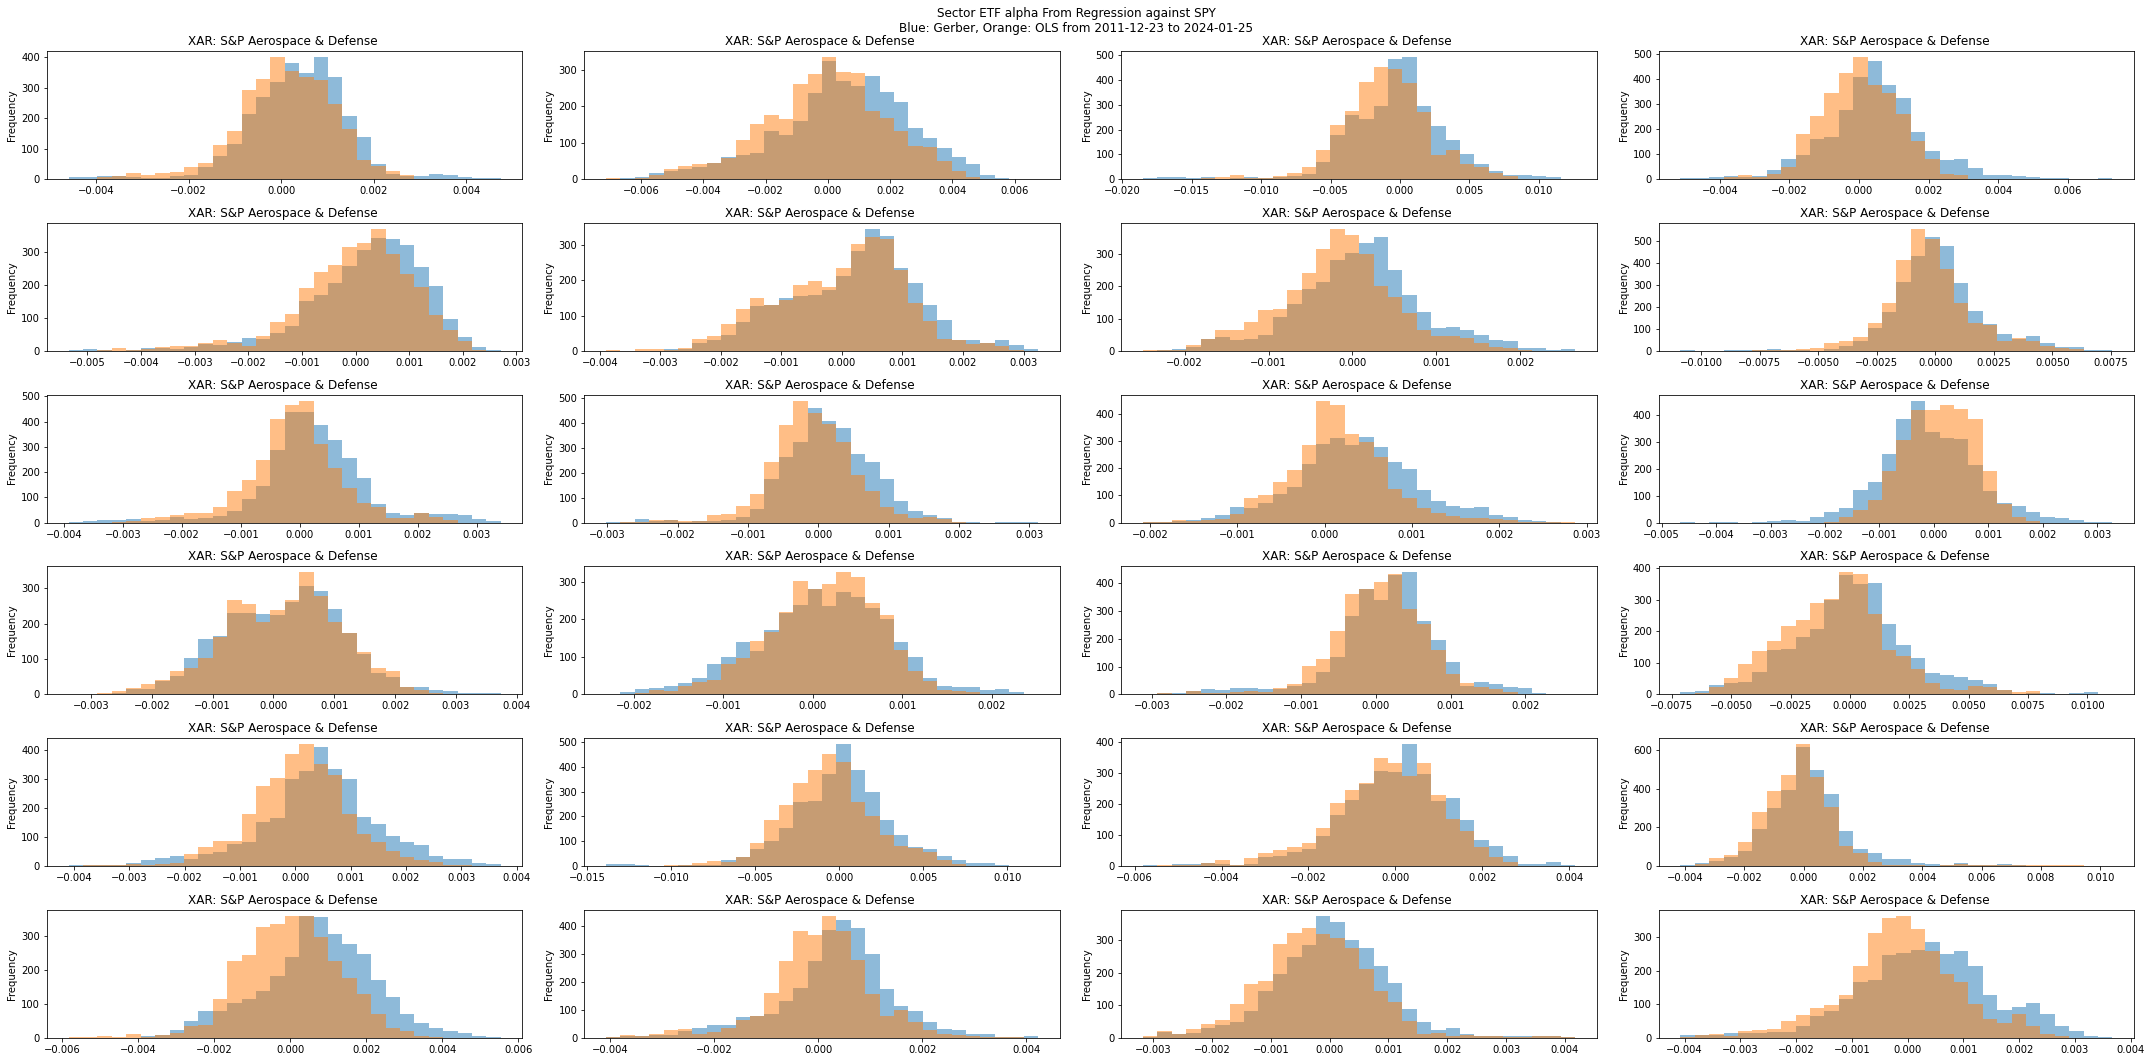

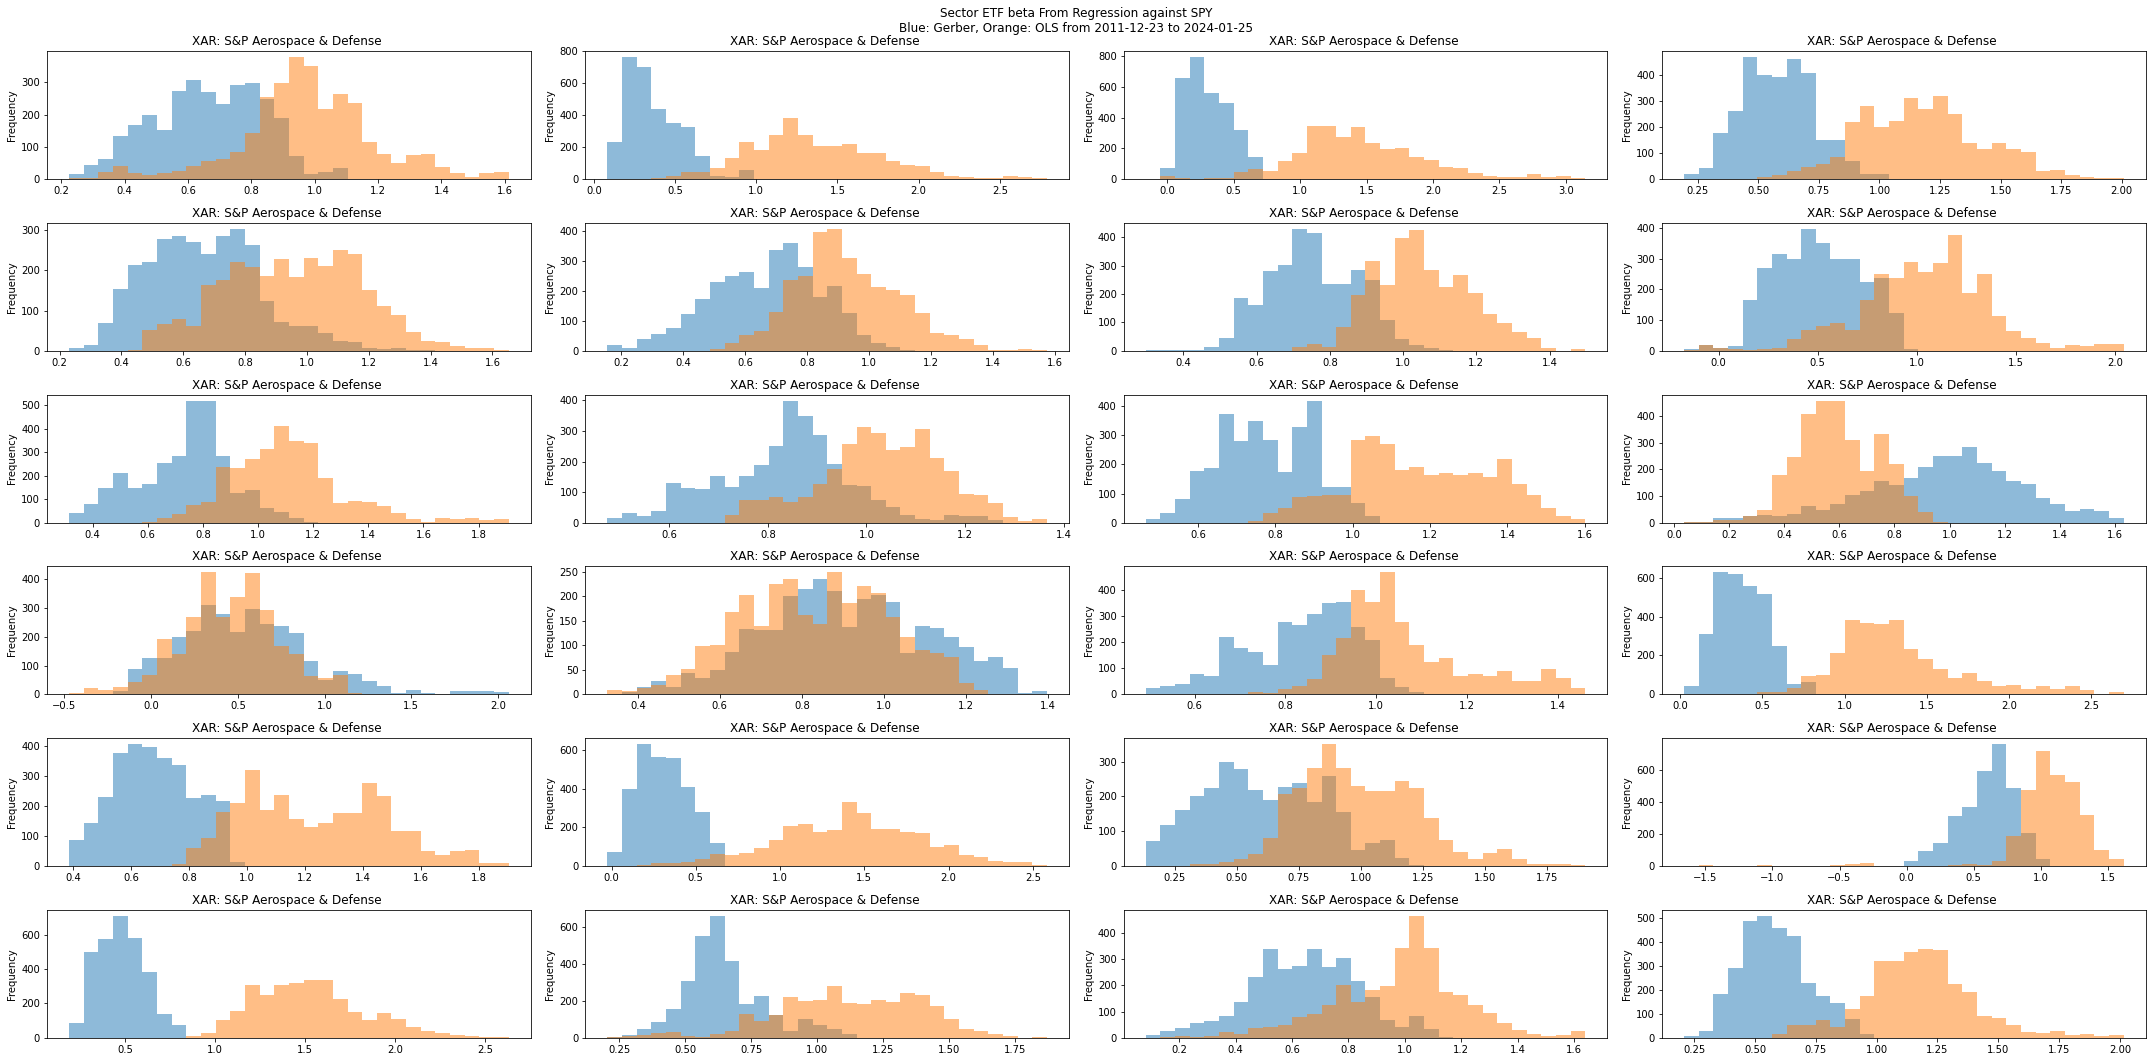

In [103]:
make_hist_chart(df_regression, "alpha")
make_hist_chart(df_regression, "beta")